<div class="alert alert-info">
<H2> Capstone 1 Predictive Maintenance </H2>
<H3> Modeling </H3>
    
Steps involved:
    <ol>
        <li>___Import libraries and data___</li>
        <li>___Select modeling technique___: As the second step in this phase of the project: modeling, I will select the actual modeling technique that I will be applying. </li>
        <li>___Generate test design___: Before I actually build a model, I need to generate the procedure or mechanism to test the model’s validity and quality. This process may include for example, in supervised data mining tasks such as classification, it is common to use error rates as a quality measure for modeling. Accordingly, I will split the dataset into 1 — a training set, and 2.  a testing set, while building the model on the training set, and estimating its quality on the separate testing set.</li>
        <li>___Build model___: Here I will run the modeling tool on the prepared dataset to create one or more models.</li>
        <li>___Assess the model___: Here I will interpret the models according to my domain knowledge, the data mining success criteria, and the anticipated test design. I will also decide on the success of the application of the modeling and discovery methods technically, may contact with concerned business analysts and domain experts later to discuss data mining results in the appropriate business perspective. While this task considers models, the evaluation phase (Phase 5) further takes into account all other effects that occurred in the course of this analysis.
At this stage, it is also important to rank the constructed models while assessing them according to any evaluation criteria. I will take the business objectives' success criteria into account as far as possible here.
</li>
    </ol>
    


<div class="alert alert-success">
<H3> Step 1. Import libraries and data </H3>

In [1]:
# imports
import pandas as pd
import numpy as np
from IPython.core.display import HTML

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# statistical processing
from xgboost import XGBClassifier, cv, plot_importance
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas.core.algorithms as algos
from pandas import Series
from scipy import stats
import scipy.stats.stats as stats
import re
import traceback
import string

# data viz imports
import seaborn as sns
import matplotlib.pyplot as plt

# viz styling
%matplotlib inline

# for reading csv files
import os
# for reading csv files
import glob 
# for trig on angles
import math 
# to search strings for nums
import re
# to combine final dfs into a single df
from functools import reduce 

# load data
df1 = pd.read_csv('data/upsampled.csv')

<div class="alert alert-success">
<H3> Step 2. Select modeling technique </H3>
    
Sub-Steps involved:
    <ol>
        <li>___Modeling technique___: I have documented the actual modeling technique utilized. </li>
        <li>___Modelling assumptions___: Many modelling techniques make specific assumptions about the data, for example that all attributes have uniform distributions, no missing values allowed, class attribute must be symbolic etc. Record any assumptions made.</li>
    </ol>

<div class="alert alert-warning">
<H3>Findings </H3>
    
Steps involved:
    <ol>
        <li>Based on the data set we have it is proper to deploy either a random forest model and or a logistic regression model as the x-variables (independent) are of a consistent shape with the y-variable (dependent). Logistics regression is applicable when we have one nominal variable with two values (male/female, 0/1, etc.) and one measurement variable. The nominal variable is the dependent variable, and the measurement variable is the independent variable. Additionally, because we are dealing with a nominal variable (1 or 0): 'NORMAL': '0', 'RECOVERING': '0', 'BROKEN': '1', we could use a logistic regression model.</li>
        <li>In machine learning, the random forest algorithm is also known as the random forest classifier. It is a very popular classification algorithm. One of the most interesting thing about this algorithm is that it can be used as both classification and regression algorithm. A random forest algorithm creates multiple decision trees and merges them together to obtain a more stable and accurate prediction. In general, the more trees in the forest, the more robust would be the prediction and thus higher accuracy.</li>
        </ol>

<div class="alert alert-success">
<H3> Step 3. Generate test design </H3>
    
Sub-Steps involved:
    <ol>
        <li>Here I will describe the intended plan for training, testing, and evaluating the select modeling effort. A chief component of the process here is determining how to divide the available dataset into training, and testing datasets. </li>
    </ol>

In [2]:
# create x (independent) and y(target) variables
X = df1.drop('machine_status', axis=1) 
y = df1['machine_status'].values

# split data into test and training sets
# set seed to 42 so no matter how many times you execute your code the result would be the same . i.e, same values in train and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
# the below function will help us look at the variance inflation factor

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [4]:
final_iv, IV = data_vars(X_train, y_train)

C:\Users\alfre\Anaconda3\lib\site-packages\pandas\core\series.py:645: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# looking at the sum of squares per each variable

IV

,VAR_NAME,IV
0,sensor_00,0.716733
1,sensor_01,0.521451
2,sensor_02,0.041447
3,sensor_03,0.340073
4,sensor_04,0.730574
5,sensor_05,1.395991
6,sensor_06,0.471535
7,sensor_07,0.000260
8,sensor_08,0.035467
9,sensor_09,0.147861


<div class="alert alert-success">
<H3> Step 4. Build the model </H3>
    
Sub-Steps involved:
    <ol>
        <li>___Parameter settings___: there are often a large number of parameters that can be adjusted here and with any modeling tool. Here I will list the parameters along with their chosen values, and my rationale for the choice of the parameter settings.</li>
        <li>___Models___: Here, I will state the actual models produced by the modeling tool.</li>
        <li>___Model descriptions___: Here, I will describe the resulting models, report on the interpretation of the models and document any difficulties encountered with their meanings.</li>
    </ol>

In [6]:
# step 1. feature selection
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]

def iterate_vif(df, vif_threshold=5, max_vif=6):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    
    if vif['VIFactor'].max() > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = vif['VIFactor'].max()
    else:
        print('Complete')
        return df, vif.sort_values('VIFactor')
X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing sensor_20 with VIF of 6314.432912
Iteration # 2
Removing sensor_19 with VIF of 4586.585007
Iteration # 3
Removing sensor_21 with VIF of 1757.113815
Iteration # 4
Removing sensor_03 with VIF of 1486.603558
Iteration # 5
Removing sensor_16 with VIF of 1404.669728
Iteration # 6
Removing sensor_22 with VIF of 982.335652
Iteration # 7
Removing sensor_17 with VIF of 891.504907
Iteration # 8
Removing sensor_25 with VIF of 719.024628
Iteration # 9
Removing sensor_01 with VIF of 634.370878
Iteration # 10
Removing sensor_23 with VIF of 551.214406
Iteration # 11
Removing sensor_14 with VIF of 314.252800
Iteration # 12
Removing sensor_41 with VIF of 313.459153
Iteration # 13
Removing sensor_43 with VIF of 301.909730
Iteration # 14
Removing sensor_24 with VIF of 216.363708
Iteration # 15
Removing sensor_09 with VIF of 188.875914
Iteration # 16
Removing sensor_39 with VIF of 162.039360
Iteration # 17
Removing sensor_02 with VIF of 122.339912
Iteration # 18
Removing sensor_26 w

In [7]:
X_train = final_df

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205625 entries, 238128 to 121958
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sensor_13  205625 non-null  float64
 1   sensor_34  205625 non-null  float64
 2   sensor_37  205625 non-null  float64
 3   sensor_38  205625 non-null  float64
 4   sensor_48  205625 non-null  float64
dtypes: float64(5)
memory usage: 9.4 MB


In [10]:
def run_regression_accuracy(X_train, y_train, X_test, y_test):
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  print('\nConfusion matrix: \n',cm)

  print('\nClassification report: \n',classification_report(y_test, y_pred))

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  return logreg

In [18]:
X_test = X_test[X_train.columns]
X_test

,sensor_13,sensor_34,sensor_37,sensor_38,sensor_48
186015,20.193380,216.84510,12.649230,45.312500,157.696800
138786,0.069444,291.35020,66.369590,45.572910,142.071800
206803,11.781830,237.69250,13.409890,45.833330,258.101800
31921,3.110026,183.94780,97.478560,49.739580,142.071800
45782,1.915992,61.34266,94.110440,59.635410,71.469910
...,...,...,...,...,...
19083,0.425165,174.72910,85.573680,34.114580,41.087960
248001,12.217860,363.03200,44.776010,50.000000,230.324100
234651,11.076400,287.91450,30.047530,48.697910,99.537030
126737,0.865070,85.07249,20.287874,51.041660,46.296300


<div class="alert alert-success">
<H3> Step 5. Assess the model </H3>
    
Sub-Steps involved:
    <ol>
        <li>___Model assessment___: Here, I will summarize the results of this task, list the qualities of the generated models (e.g.in terms of accuracy) , and rank their performance to each other.</li>
        <li>___Revised parameter settings___: Here, I will state the actual models produced by the modeling tool.</li>
        <li>___Model descriptions___: Corresponding to the model assessment, here I will revise parameter settings and tune them for the next modeling run. Iterate model building and evaluation until I firmly believe that I have found the best model(s). Additionally, I will document any such revisions and assessments for reproducibility.</li>
    </ol>

In [17]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

import statsmodels.api as sm
logit_model=sm.Logit(y, X)
result=logit_model.fit()
print(result.summary())

Training set score: 0.785
Test set score: 0.787
Optimization terminated successfully.
         Current function value: 0.004796
         Iterations 20
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               293751
Model:                          Logit   Df Residuals:                   293701
Method:                           MLE   Df Model:                           49
Date:                Sun, 01 Mar 2020   Pseudo R-squ.:                  0.9915
Time:                        19:17:01   Log-Likelihood:                -1408.8
converged:                       True   LL-Null:                   -1.6519e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sensor_00    -23.9095      0.938    -25.492      0.000     

Accuracy of logistic regression classifier on test set: 0.79

Confusion matrix: 
 [[66147    54]
 [18743  3182]]

Classification report: 
               precision    recall  f1-score   support

         0.0       0.78      1.00      0.88     66201
         1.0       0.98      0.15      0.25     21925

    accuracy                           0.79     88126
   macro avg       0.88      0.57      0.56     88126
weighted avg       0.83      0.79      0.72     88126



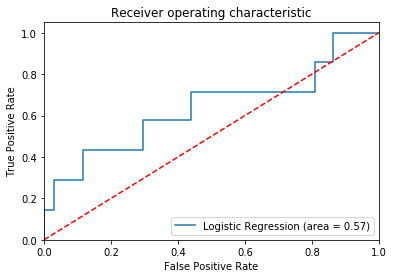

In [12]:
logreg = run_regression_accuracy(X_train, y_train, X_test, y_test)